In [1]:
import os
import random
import platform
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from wordcloud import WordCloud
from pprint import pprint

import re
import string
from collections import Counter
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams
import pickle
import spacy
# nltk.download('wordnet')
# nltk.download('all-corpora')
# nltk.download()

import transformers
from transformers import (BertModel, BertTokenizer, AutoTokenizer, RobertaTokenizer, RobertaModel, 
                          DistilBertTokenizer, DistilBertModel, 
                          ElectraTokenizer, ElectraModel,
                          MobileBertTokenizer, MobileBertModel,
                          AdamW, get_linear_schedule_with_warmup)

import sklearn
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR

import warnings
warnings.filterwarnings("ignore")

In [2]:
class Config:
    EPOCHS = 3
    MAX_LEN = 80
    BATCH_SIZE = 64
    MODEL_NAMES = ["bert-base-uncased",
                   "roberta-base",
                   "distilbert-base-uncased",
                   "google/electra-small-discriminator",
                   "google/mobilebert-uncased"
                  ]
    
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
def get_device():
    global DEVICE
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device('cuda:0')
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device('cpu')
        
RANDOM_SEED = 42
set_seed(RANDOM_SEED)
get_device()

[INFO] Using GPU: Tesla P100-PCIE-16GB



In [3]:
!nvidia-smi

Sun Mar 19 08:48:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    31W / 250W |   1205MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# df = pd.read_csv('/kaggle/input/nlp-ios-research-user-comments/combined_df.csv', encoding = 'utf-8-sig')
# df

In [5]:
# def get_dataset_stats(df):
#     print(df.isna().sum())
#     print('============================')
#     print('Total Missing Values: ', df.isna().sum().sum())
#     print('============================')
    
# get_dataset_stats(df)

In [6]:
# df = df.drop_duplicates()
# df = df.dropna()
# df

In [7]:
# get_dataset_stats(df)

In [8]:
# def plot_label_counts(df):

#     plt.figure(figsize = (10, 6))
#     ax = plt.axes()
#     ax = sns.countplot(x = 'rating', data = df)
#     plt.title('Label Count', fontsize = 20)
#     plt.xlabel('Type of Cyberbullying', fontsize = 15)
#     plt.ylabel('Count', fontsize = 15)
#     ax.xaxis.set_tick_params(labelsize = 12)
#     ax.yaxis.set_tick_params(labelsize = 12)
#     bbox_args = dict(boxstyle = 'round', fc = '0.9')
#     for p in ax.patches:
#             ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.18, p.get_height() + 110), 
#                        color = 'black',
#                        bbox = bbox_args,
#                        fontsize = 13)
#     plt.show()
    
# plot_label_counts(df)

In [9]:
# X = np.array(df['review_description']).reshape(-1, 1)
# y = np.array(df['rating'])

# print(Counter(y))

# ros = RandomOverSampler(sampling_strategy='all', random_state=RANDOM_SEED)

# X, y = ros.fit_resample(X, y)

# assert len(X) == len(y)
# print(Counter(y))

# df = pd.DataFrame({"review_description": X.flatten(), "rating": y})
# df

In [10]:
# plot_label_counts(df)

In [11]:
# stop_words = list(stopwords.words('english'))

# def remove_urls(text):
#     urls = re.compile(r'https?://\S+|www\.\S+')
#     return urls.sub(r'', text)

# def remove_HTML(text):
#     html = re.compile('<.*?>')
#     return html.sub(r'', text)

# def remove_emoji(text):
#     emoji_pattern = re.compile('['
#                            u'\U0001F600-\U0001F64F'
#                            u'\U0001F300-\U0001F5FF'
#                            u'\U0001F680-\U0001F6FF'
#                            u'\U0001F1E0-\U0001F1FF'
#                            u'\U00002702-\U000027B0'
#                            u'\U000024C2-\U0001F251'
#                            ']+', flags=re.UNICODE)
#     return emoji_pattern.sub(r'', text)

# def remove_emoticons(text):
#     emoticons = {
#         u":‑\)":"Happy face or smiley",
#         u":\)":"Happy face or smiley",
#         u":-\]":"Happy face or smiley",
#         u":\]":"Happy face or smiley",
#         u":-3":"Happy face smiley",
#         u":3":"Happy face smiley",
#         u":->":"Happy face smiley",
#         u":>":"Happy face smiley",
#         u"8-\)":"Happy face smiley",
#         u":o\)":"Happy face smiley",
#         u":-\}":"Happy face smiley",
#         u":\}":"Happy face smiley",
#         u":-\)":"Happy face smiley",
#         u":c\)":"Happy face smiley",
#         u":\^\)":"Happy face smiley",
#         u"=\]":"Happy face smiley",
#         u"=\)":"Happy face smiley",
#         u":‑D":"Laughing, big grin or laugh with glasses",
#         u":D":"Laughing, big grin or laugh with glasses",
#         u"8‑D":"Laughing, big grin or laugh with glasses",
#         u"8D":"Laughing, big grin or laugh with glasses",
#         u"X‑D":"Laughing, big grin or laugh with glasses",
#         u"XD":"Laughing, big grin or laugh with glasses",
#         u"=D":"Laughing, big grin or laugh with glasses",
#         u"=3":"Laughing, big grin or laugh with glasses",
#         u"B\^D":"Laughing, big grin or laugh with glasses",
#         u":-\)\)":"Very happy",
#         u":‑\(":"Frown, sad, andry or pouting",
#         u":-\(":"Frown, sad, andry or pouting",
#         u":\(":"Frown, sad, andry or pouting",
#         u":‑c":"Frown, sad, andry or pouting",
#         u":c":"Frown, sad, andry or pouting",
#         u":‑<":"Frown, sad, andry or pouting",
#         u":<":"Frown, sad, andry or pouting",
#         u":‑\[":"Frown, sad, andry or pouting",
#         u":\[":"Frown, sad, andry or pouting",
#         u":-\|\|":"Frown, sad, andry or pouting",
#         u">:\[":"Frown, sad, andry or pouting",
#         u":\{":"Frown, sad, andry or pouting",
#         u":@":"Frown, sad, andry or pouting",
#         u">:\(":"Frown, sad, andry or pouting",
#         u":'‑\(":"Crying",
#         u":'\(":"Crying",
#         u":'‑\)":"Tears of happiness",
#         u":'\)":"Tears of happiness",
#         u"D‑':":"Horror",
#         u"D:<":"Disgust",
#         u"D:":"Sadness",
#         u"D8":"Great dismay",
#         u"D;":"Great dismay",
#         u"D=":"Great dismay",
#         u"DX":"Great dismay",
#         u":‑O":"Surprise",
#         u":O":"Surprise",
#         u":‑o":"Surprise",
#         u":o":"Surprise",
#         u":-0":"Shock",
#         u"8‑0":"Yawn",
#         u">:O":"Yawn",
#         u":-\*":"Kiss",
#         u":\*":"Kiss",
#         u":X":"Kiss",
#         u";‑\)":"Wink or smirk",
#         u";\)":"Wink or smirk",
#         u"\*-\)":"Wink or smirk",
#         u"\*\)":"Wink or smirk",
#         u";‑\]":"Wink or smirk",
#         u";\]":"Wink or smirk",
#         u";\^\)":"Wink or smirk",
#         u":‑,":"Wink or smirk",
#         u";D":"Wink or smirk",
#         u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
#         u":‑\|":"Straight face",
#         u":\|":"Straight face",
#         u":$":"Embarrassed or blushing",
#         u":‑x":"Sealed lips or wearing braces or tongue-tied",
#         u":x":"Sealed lips or wearing braces or tongue-tied",
#         u":‑#":"Sealed lips or wearing braces or tongue-tied",
#         u":#":"Sealed lips or wearing braces or tongue-tied",
#         u":‑&":"Sealed lips or wearing braces or tongue-tied",
#         u":&":"Sealed lips or wearing braces or tongue-tied",
#         u"O:‑\)":"Angel, saint or innocent",
#         u"O:\)":"Angel, saint or innocent",
#         u"0:‑3":"Angel, saint or innocent",
#         u"0:3":"Angel, saint or innocent",
#         u"0:‑\)":"Angel, saint or innocent",
#         u"0:\)":"Angel, saint or innocent",
#         u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
#         u"0;\^\)":"Angel, saint or innocent",
#         u">:‑\)":"Evil or devilish",
#         u">:\)":"Evil or devilish",
#         u"\}:‑\)":"Evil or devilish",
#         u"\}:\)":"Evil or devilish",
#         u"3:‑\)":"Evil or devilish",
#         u"3:\)":"Evil or devilish",
#         u">;\)":"Evil or devilish",
#         u"\|;‑\)":"Cool",
#         u"\|‑O":"Bored",
#         u":‑J":"Tongue-in-cheek",
#         u"#‑\)":"Party all night",
#         u"%‑\)":"Drunk or confused",
#         u"%\)":"Drunk or confused",
#         u":-###..":"Being sick",
#         u":###..":"Being sick",
#         u"<:‑\|":"Dump",
#         u"\(>_<\)":"Troubled",
#         u"\(>_<\)>":"Troubled",
#         u"\(';'\)":"Baby",
#         u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
#         u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
#         u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
#         u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
#         u"\(-_-\)zzz":"Sleeping",
#         u"\(\^_-\)":"Wink",
#         u"\(\(\+_\+\)\)":"Confused",
#         u"\(\+o\+\)":"Confused",
#         u"\(o\|o\)":"Ultraman",
#         u"\^_\^":"Joyful",
#         u"\(\^_\^\)/":"Joyful",
#         u"\(\^O\^\)／":"Joyful",
#         u"\(\^o\^\)／":"Joyful",
#         u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
#         u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
#         u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
#         u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
#         u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
#         u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
#         u"\('_'\)":"Sad or Crying",
#         u"\(/_;\)":"Sad or Crying",
#         u"\(T_T\) \(;_;\)":"Sad or Crying",
#         u"\(;_;":"Sad of Crying",
#         u"\(;_:\)":"Sad or Crying",
#         u"\(;O;\)":"Sad or Crying",
#         u"\(:_;\)":"Sad or Crying",
#         u"\(ToT\)":"Sad or Crying",
#         u";_;":"Sad or Crying",
#         u";-;":"Sad or Crying",
#         u";n;":"Sad or Crying",
#         u";;":"Sad or Crying",
#         u"Q\.Q":"Sad or Crying",
#         u"T\.T":"Sad or Crying",
#         u"QQ":"Sad or Crying",
#         u"Q_Q":"Sad or Crying",
#         u"\(-\.-\)":"Shame",
#         u"\(-_-\)":"Shame",
#         u"\(一一\)":"Shame",
#         u"\(；一_一\)":"Shame",
#         u"\(=_=\)":"Tired",
#         u"\(=\^\·\^=\)":"cat",
#         u"\(=\^\·\·\^=\)":"cat",
#         u"=_\^=	":"cat",
#         u"\(\.\.\)":"Looking down",
#         u"\(\._\.\)":"Looking down",
#         u"\^m\^":"Giggling with hand covering mouth",
#         u"\(\・\・?":"Confusion",
#         u"\(?_?\)":"Confusion",
#         u">\^_\^<":"Normal Laugh",
#         u"<\^!\^>":"Normal Laugh",
#         u"\^/\^":"Normal Laugh",
#         u"\（\*\^_\^\*）" :"Normal Laugh",
#         u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
#         u"\(^\^\)":"Normal Laugh",
#         u"\(\^\.\^\)":"Normal Laugh",
#         u"\(\^_\^\.\)":"Normal Laugh",
#         u"\(\^_\^\)":"Normal Laugh",
#         u"\(\^\^\)":"Normal Laugh",
#         u"\(\^J\^\)":"Normal Laugh",
#         u"\(\*\^\.\^\*\)":"Normal Laugh",
#         u"\(\^—\^\）":"Normal Laugh",
#         u"\(#\^\.\^#\)":"Normal Laugh",
#         u"\（\^—\^\）":"Waving",
#         u"\(;_;\)/~~~":"Waving",
#         u"\(\^\.\^\)/~~~":"Waving",
#         u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
#         u"\(T_T\)/~~~":"Waving",
#         u"\(ToT\)/~~~":"Waving",
#         u"\(\*\^0\^\*\)":"Excited",
#         u"\(\*_\*\)":"Amazed",
#         u"\(\*_\*;":"Amazed",
#         u"\(\+_\+\) \(@_@\)":"Amazed",
#         u"\(\*\^\^\)v":"Laughing,Cheerful",
#         u"\(\^_\^\)v":"Laughing,Cheerful",
#         u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
#         u'\(-"-\)':"Worried",
#         u"\(ーー;\)":"Worried",
#         u"\(\^0_0\^\)":"Eyeglasses",
#         u"\(\＾ｖ\＾\)":"Happy",
#         u"\(\＾ｕ\＾\)":"Happy",
#         u"\(\^\)o\(\^\)":"Happy",
#         u"\(\^O\^\)":"Happy",
#         u"\(\^o\^\)":"Happy",
#         u"\)\^o\^\(":"Happy",
#         u":O o_O":"Surprised",
#         u"o_0":"Surprised",
#         u"o\.O":"Surpised",
#         u"\(o\.o\)":"Surprised",
#         u"oO":"Surprised",
#         u"\(\*￣m￣\)":"Dissatisfied",
#         u"\(‘A`\)":"Snubbed or Deflated"
#     }
#     emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in emoticons) + u')')
#     return emoticon_pattern.sub(r'', text)

# def remove_mentions(text):
#     mentions = re.compile('@[A-Za-z0-9_]+')
#     return mentions.sub(r'', text)

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# def lemmatization(text):
#     doc = nlp(text)    
#     doc = " ".join([token.lemma_ for token in doc])
#     doc = doc.replace("\n", "")
#     return doc

# df['review_description'] = df['review_description'].str.lower() # convert to lowercase
# print("Lowercasing Done!!")

# df['review_description'] = df['review_description'].apply(lambda text: remove_urls(text)) # remove URLs
# print("URL Removal Done!!")

# df['review_description'] = df['review_description'].apply(lambda text: remove_HTML(text)) # remove HTML tags
# print("HTML Removal Done!!")

# df['review_description'] = df['review_description'].str.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
# print("Punctuation Removal Done!!")

# df['review_description'] = df['review_description'].apply(lambda text: ' '.join([word for word in str(text).split() if word not in stop_words])) # remove stopwords
# print("Stopwords Removal Done!!")

# df['review_description'] = df['review_description'].apply(lambda text: remove_emoji(text)) # remove emojis
# print("Emoji Removal Done!!")

# df['review_description'] = df['review_description'].apply(lambda text: remove_emoticons(text)) # remove emoticons
# print("Emoticon Removal Done!!")

# df['review_description'] = df['review_description'].apply(lambda text: remove_mentions(text)) # remove mentions
# print("Mention Removal Done!!")

# df['review_description'] = df['review_description'].apply(lambda text: lemmatization(text)) # lemmatizing the words
# print("Word Lemmatization Done!!")

# # df['review_description'] = df['review_description'].apply(lambda text: th.cont_exp(text)) # convert i'm to i am, you're to you are, etc

# print("Preprocessed Data:")
# df['review_description']

In [12]:
# df.to_csv('preprocessed_dataset_original.csv',
#                 index = False, encoding = 'utf-8-sig')
# print("Preprocessed Dataframe Saved!!")

In [13]:
# df['rating'].value_counts()

In [14]:
df = pd.read_csv('/kaggle/input/nlp-ios-research-user-comments/preprocessed_dataset_original.csv', encoding = 'utf-8-sig')
df

,review_description,rating
0,find first cousin dad side god send last gener...,5.0
1,love 23andme app well explain step process sen...,5.0
2,overall it ’ good app user friendly part beaut...,3.0
3,it ’ good app could have not figure scroll pho...,4.0
4,past couple update 23andme increasingly make a...,2.0
...,...,...
597263,love app happen upon app search new fun game a...,5.0
597264,dziala idealniebardzo pomocna fajna,5.0
597265,do not take account proportion size seem inacc...,1.0
597266,think app great first show friend demonstrate ...,1.0


In [15]:
# bbox_args = dict(boxstyle = 'round', fc = '0.9')

# def generate_ngrams(text, n_gram = 0):
#     token = [token for token in str(text).lower().split(' ') if token != '' if token not in stop_words]
#     ngrams = zip(*[token[i:] for i in range(n_gram)])
#     return [' '.join(ngram) for ngram in ngrams]

# def generate_ngram_dictionary(n_gram):
#     dataset_ngrams = defaultdict(int)
    
#     for review in df['review_description']:
#         for word in generate_ngrams(review, n_gram = n_gram):
#             dataset_ngrams[word] += 1
            
#     dataset_ngrams = dict(sorted(dataset_ngrams.items(), key = lambda x: x[1], reverse = True)[:10])
#     dataset_ngram_words = list(dataset_ngrams.keys())
#     dataset_ngram_freq = list(dataset_ngrams.values())
    
#     return dataset_ngrams, dataset_ngram_words, dataset_ngram_freq

# def generate_ngram_barplot(dataset_ngram_freq, dataset_ngram_words, type_of_ngram):
#     plt.figure(figsize = (15, 10))
#     ax = plt.axes()
#     ax = sns.barplot(x = dataset_ngram_freq, y = dataset_ngram_words)
#     plt.title(type_of_ngram.title(), fontsize = 25)
#     plt.xlabel('Count', fontsize = 20)
#     plt.ylabel('Words', fontsize = 20)
#     ax.xaxis.set_tick_params(labelsize = 15)
#     ax.yaxis.set_tick_params(labelsize = 15)
#     for p in ax.patches:
#             width = p.get_width()
#             ax.text(0.75 + p.get_width(), p.get_y() + 0.5 * p.get_height(), '{:1.0f}'.format(width), 
#                      ha = 'center', 
#                      va = 'center', 
#                      bbox = bbox_args, 
#                      fontsize = 15)
#     plt.show()

# _, dataset_unigram_words, dataset_unigram_freq = generate_ngram_dictionary(1)
# _, dataset_bigram_words, dataset_bigram_freq = generate_ngram_dictionary(2)
# _, dataset_trigram_words, dataset_trigram_freq = generate_ngram_dictionary(3)

# generate_ngram_barplot(dataset_unigram_freq, dataset_unigram_words, 'unigram')
# generate_ngram_barplot(dataset_bigram_freq, dataset_bigram_words, 'bigram')
# generate_ngram_barplot(dataset_trigram_freq, dataset_trigram_words, 'trigram')

In [16]:
# wordcloud = WordCloud(width = 1400, height = 600, background_color = 'black').generate(''.join(str(text) for text in df['review_description']))
# plt.figure(figsize = (20, 10))
# plt.title('Wordcloud Visualization of reviews', fontsize = 25)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

In [17]:
# y = df['rating']

# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
# class_weights = torch.tensor(class_weights, dtype=torch.float)
 
# print(class_weights)

In [18]:
df['rating'] = df['rating'].astype('int')
df['rating']

0         5
1         5
2         3
3         4
4         2
         ..
597263    5
597264    5
597265    1
597266    1
597267    5
Name: rating, Length: 597268, dtype: int64

In [19]:
df['rating'].value_counts()

5    324133
1    114532
4     76027
3     44915
2     37661
Name: rating, dtype: int64

In [20]:
le = LabelEncoder()
df["rating"] = le.fit_transform(df["rating"])
# print(le.classes_)
print(df["rating"].value_counts())

4    324133
0    114532
3     76027
2     44915
1     37661
Name: rating, dtype: int64


In [21]:
df = df.dropna()

df_train, df_test = train_test_split(df, test_size = 0.1, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)
print(f'Train shape: {df_train.shape}')
print(f'Validation shape: {df_val.shape}')
print(f'Test shape: {df_test.shape}')

Train shape: (536697, 2)
Validation shape: (29816, 2)
Test shape: (29817, 2)


In [22]:
tokenizer = ElectraTokenizer.from_pretrained(Config.MODEL_NAMES[3])
model = ElectraModel.from_pretrained(Config.MODEL_NAMES[3])

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
class UserReviewDataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, i):
        review = str(self.reviews[i])
        target = self.targets[i]
        
        encoding = self.tokenizer.encode_plus(
            review,
            max_length = self.max_len,
            truncation = True,
            add_special_tokens = True,
            return_token_type_ids = False,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt'
        )
        
        return {
            "review": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype = torch.long)
        }

In [24]:
def create_dataloader(df, tokenizer, max_len, batch_size):
    
    ds = UserReviewDataset(
        reviews = df["review_description"].to_numpy(),
        targets = df["rating"].to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )
    
    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 8
    )

train_data_loader = create_dataloader(df_train, tokenizer, Config.MAX_LEN, Config.BATCH_SIZE)
val_data_loader = create_dataloader(df_val, tokenizer, Config.MAX_LEN, Config.BATCH_SIZE)
test_data_loader = create_dataloader(df_test, tokenizer, Config.MAX_LEN, Config.BATCH_SIZE)

In [25]:
class ELECTRA(nn.Module):
    
    def __init__(self, n_classes):
        super(ELECTRA, self).__init__()
        self.bert = ElectraModel.from_pretrained(Config.MODEL_NAMES[3])
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.25),
            nn.BatchNorm1d(self.bert.config.hidden_size),
            nn.Linear(self.bert.config.hidden_size, 32),
            nn.ReLU(inplace = True),
            nn.Linear(32, n_classes)
        )
        
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids = input_ids, attention_mask = attention_mask)
        last_hidden_state = output.last_hidden_state
        cls_token_state = last_hidden_state[:, 0, :]
        logits = self.classifier(cls_token_state)
        return logits

In [26]:
model = ELECTRA(len(le.classes_))
model = model.to(DEVICE)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 5e-8, correct_bias = False)
total_steps = len(train_data_loader) * Config.EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps = 0,
  num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

In [28]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for i in data_loader:
        input_ids = i["input_ids"].to(DEVICE)
        attention_mask = i["attention_mask"].to(DEVICE)
        targets = i["targets"].to(DEVICE)
        
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for i in data_loader:
            input_ids = i["input_ids"].to(device)
            attention_mask = i["attention_mask"].to(device)
            targets = i["targets"].to(device)
            
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            
            _, preds = torch.max(outputs, dim = 1)
            
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
%%time

history = defaultdict(list)
best_accuracy = 0
model_name = Config.MODEL_NAMES[3]
model_name = model_name.split('/')[-1]
print(f"Training {model_name}")

for epoch in range(Config.EPOCHS):
    print(f'Epoch {epoch + 1} / {Config.EPOCHS}')
    print('=' * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, DEVICE, scheduler, len(df_train))
    print(f'Train loss: {train_loss}\nTrain accuracy: {train_acc}\n')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, DEVICE, len(df_val))
    print(f'Val loss: {val_loss}\nVal accuracy: {val_acc}\n')
    
#     print(f'Learning Rate: {scheduler.get_last_lr()}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)    
    
    if(val_acc > best_accuracy):
        torch.save(model.state_dict(), 
                   f'{model_name}_epochs_{Config.EPOCHS}_maxlen_{Config.MAX_LEN}_batchsize_{Config.BATCH_SIZE}.bin')
        best_accuracy = val_acc

Training electra-small-discriminator
Epoch 1 / 3
Train loss: 0.8030751013660556
Train accuracy: 0.70297765778456

Val loss: 0.7415326821573814
Val accuracy: 0.7222296753420981

Epoch 2 / 3
Train loss: 0.7406223848757072
Train accuracy: 0.723054162777135

Val loss: 0.7252305934101727
Val accuracy: 0.7259860477595921

Epoch 3 / 3
Train loss: 0.7195113251808006
Train accuracy: 0.7304028157414706

Val loss: 0.721789391959174
Val accuracy: 0.7296753420982023

CPU times: user 42min 59s, sys: 19.5 s, total: 43min 18s
Wall time: 46min 53s


In [31]:
test_acc, _ = eval_model(
      model,
      test_data_loader,
      loss_fn,
      DEVICE,
      len(df_test)
    )

print(f"Test accuracy = {test_acc.item() * 100}%")

Test accuracy = 72.95502565650469%


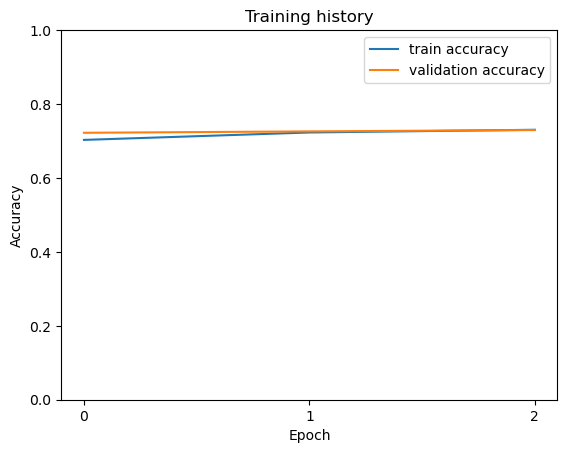

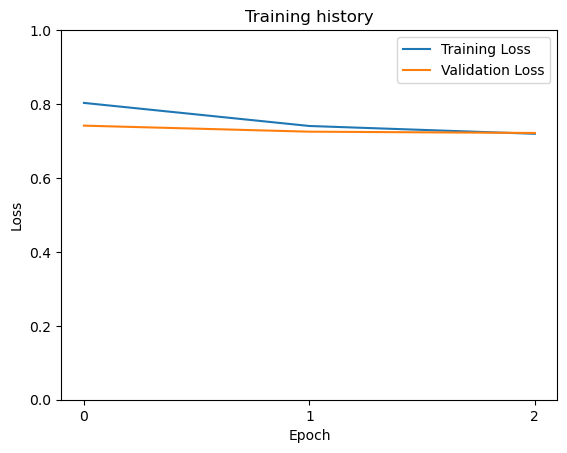

In [32]:
def generate_acc_loss_plots(history):
    
    train_acc = [tensor.detach().cpu().numpy() for tensor in history['train_acc']]
    val_acc = [tensor.detach().cpu().numpy() for tensor in history['val_acc']]
    
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(train_acc, label='train accuracy')
    plt.plot(val_acc, label='validation accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    
generate_acc_loss_plots(history)

with open(f'history_{model_name}_epochs_{Config.EPOCHS}_maxlen_{Config.MAX_LEN}_batchsize_{Config.BATCH_SIZE}.pkl', 
          'wb') as f:
    pickle.dump(history, f)

In [33]:
def get_predictions(model, data_loader):
    
    model = model.eval()
    
    review_list = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for i in data_loader:
            reviews = i["review"]
            input_ids = i["input_ids"].to(DEVICE)
            attention_mask = i["attention_mask"].to(DEVICE)
            targets = i["targets"].to(DEVICE)
            
            outputs = model(input_ids, attention_mask = attention_mask)
            
            _, preds = torch.max(outputs, dim = 1)
            
            review_list.extend(reviews)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return reviews, predictions, prediction_probs, real_values

In [34]:
def plot_confusion_matrix(confusion_matrix):
    
    plt.figure(figsize = (12, 8))
    ax = plt.axes()
    ax = sns.heatmap(confusion_matrix, annot = True, square = True, fmt = "d", cmap = "Blues", cbar = False, annot_kws={'size': 15},
                    xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    ax.xaxis.set_tick_params(labelsize = 10)
    ax.yaxis.set_tick_params(labelsize = 10)
    plt.title("Confusion Matrix", fontsize = 15)
    plt.ylabel("Actual Classes", fontsize = 15)
    plt.xlabel("Predicted Classes", fontsize = 15)
    plt.show()

In [35]:
y_reviews, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.85      0.73      5742
           1       0.34      0.08      0.14      1874
           2       0.35      0.25      0.29      2196
           3       0.49      0.40      0.44      3807
           4       0.86      0.90      0.88     16198

    accuracy                           0.73     29817
   macro avg       0.54      0.50      0.50     29817
weighted avg       0.70      0.73      0.71     29817



In [36]:
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")

F1 Score: 0.7051751785196947
Precision: 0.6989638190567218
Recall: 0.7295502565650468


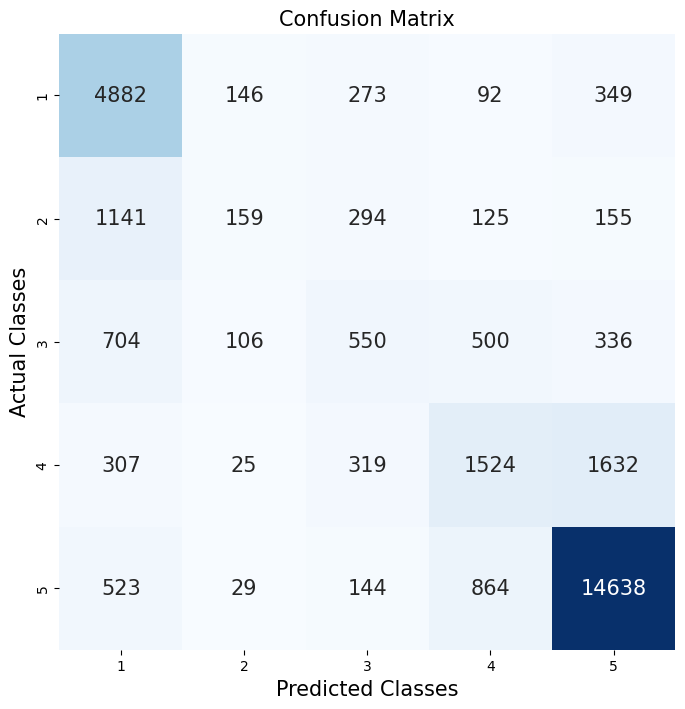

In [37]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))